# 📥 NLP 2018 - Phase 1: Veri Hazırlama

**Bu notebook'u sadece bir kez çalıştır!**

İşlemler:
1. Haber verisi çekme/yükleme
2. Türkçe → İngilizce çeviri
3. Lemmatization & Stemming

Çıktılar `/content/drive/MyDrive/Colab Notebooks/DataFrames/` klasörüne kaydedilir.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
# Bunu çalıştırdıktan sonra 'Restart Session' a bas
!pip install -q sentence-transformers deep_translator gensim fasttext beautifulsoup4 inflect requests pandas openpyxl tensorflow tensorflow-hub

In [3]:
# Veri İşleme ve Analiz
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import requests
import warnings

# Metin Ön İşleme
from bs4 import BeautifulSoup
import inflect
from deep_translator import GoogleTranslator
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet

# NLP Modelleri
import torch
from sentence_transformers import SentenceTransformer, util
from gensim.models import KeyedVectors
import gensim.downloader as api
import tensorflow_hub as hub
import fasttext
import os

# Uyarıları gizle
warnings.filterwarnings("ignore")



In [4]:
import os
import nltk

### NLTK PAKETLERINI DRIVE'A KALICI İNDİRME

DRIVE_NLTK_PATH = "/content/drive/MyDrive/Colab Notebooks/NLP Modeller/NLTK"
NLTK_PACKAGES = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng',  # YENİ! ← NLTK 3.9+ için gerekli
    'wordnet',
    'omw-1.4'
]

os.makedirs(DRIVE_NLTK_PATH, exist_ok=True)

if DRIVE_NLTK_PATH not in nltk.data.path:
    nltk.data.path.insert(0, DRIVE_NLTK_PATH)

print("🔍 NLTK paketleri kontrol ediliyor...\n")

for package in NLTK_PACKAGES:
    try:
        package_exists = False
        possible_paths = [
            os.path.join(DRIVE_NLTK_PATH, 'corpora', package),
            os.path.join(DRIVE_NLTK_PATH, 'tokenizers', package),
            os.path.join(DRIVE_NLTK_PATH, 'taggers', package),
        ]

        for path in possible_paths:
            if os.path.exists(path):
                package_exists = True
                print(f"  ✅ {package:40s} → Drive'da mevcut")
                break

        if not package_exists:
            print(f"  📥 {package:40s} → İndiriliyor...")
            nltk.download(package, download_dir=DRIVE_NLTK_PATH, quiet=True)
            print(f"  ✅ {package:40s} → Drive'a indirildi!")
    except Exception as e:
        print(f"  ❌ {package:40s} → HATA: {e}")

print("\n✅ NLTK kurulumu tamamlandı!")


🔍 NLTK paketleri kontrol ediliyor...

  ✅ punkt                                    → Drive'da mevcut
  ✅ punkt_tab                                → Drive'da mevcut
  ✅ stopwords                                → Drive'da mevcut
  ✅ averaged_perceptron_tagger               → Drive'da mevcut
  ✅ averaged_perceptron_tagger_eng           → Drive'da mevcut
  📥 wordnet                                  → İndiriliyor...
  ✅ wordnet                                  → Drive'a indirildi!
  📥 omw-1.4                                  → İndiriliyor...
  ✅ omw-1.4                                  → Drive'a indirildi!

✅ NLTK kurulumu tamamlandı!


In [5]:
# Sayıları yazıya çevirmek için inflect motorunu başlat
p = inflect.engine()

def preprocess_text(text, remove_stop_words=False):
    # Girdinin bir metin (string) olup olmadığını kontrol et, değilse boş metin döndür
    if not isinstance(text, str):
        return ""

    # HTML etiketlerini temizle
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Sayıları kelimelere çevir
    # Not: Büyük metinlerde bu işlem yavaş olabilir.
    def replace_number(match):
        number = int(match.group(0))
        return p.number_to_words(number)
    text = re.sub(r'\d+', replace_number, text)


    # Türkçe karakterleri koruyarak harf dışı karakterleri temizle
    text = re.sub('[^a-zA-ZğĞçÇşŞüÜöÖıİ]', ' ', text)
    text = text.lower()
    words = text.split()

    # İsteğe bağlı olarak stop-words (etkisiz kelimeler) kaldırma
    if remove_stop_words:
        turkish_stopwords = set(stopwords.words('turkish'))
        words = [w for w in words if not w in turkish_stopwords]

    return ' '.join(words)

In [6]:
%%capture
# Gerekli kütüphaneyi yükleyin
!pip install newsapi-python

In [7]:
# Gerekli kütüphaneyi yükleyin
!pip install gnews

from gnews import GNews
from datetime import datetime, timedelta
import pandas as pd

# --- BAŞLANGIÇ AYARLARI ---
# Bu yöntemde API anahtarına gerek YOKTUR.
# Eski tarihleri sorgulayabilirsiniz.
start_date_str = '2018-01-01'
end_date_str = '2018-12-31'

# Tarihleri datetime nesnesine dönüştürme
start_date_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date_str, '%Y-%m-%d')

# Aranacak anahtar kelimeler
keywords = [
    "borsa", "hisse senedi", "piyasa", "yatırım", "ekonomi", "ticaret",
    "finans", "para piyasası", "sermaye piyasası", "döviz", "endeks"
]
# --- BİTİŞ AYARLARI ---

# --- DÜZELTME BURADA ---
# GNews nesnesini başlatma (Önce boş başlatıp, sonra özelliklerini atamak daha garantilidir)
google_news = GNews()
google_news.language = 'tr'
google_news.country = 'TR'
# --- DÜZELTME BİTTİ ---

# Tarih aralığını ayarla
google_news.start_date = (start_date_dt.year, start_date_dt.month, start_date_dt.day)
google_news.end_date = (end_date_dt.year, end_date_dt.month, end_date_dt.day)

all_entries = []

try:
    # Her bir anahtar kelime için ayrı ayrı arama yapıp sonuçları birleştirebiliriz
    print("Haberler çekiliyor, bu işlem biraz zaman alabilir...")
    for keyword in keywords:
        json_resp = google_news.get_news(keyword)
        for item in json_resp:
            entry = {
                'Tarih': item.get('published date'),
                'Başlık': item.get('title'),
                'Metin': item.get('description')
            }
            all_entries.append(entry)

    # Tekrarlanan haberleri başlıklarına göre temizle
    if all_entries:
        temp_df = pd.DataFrame(all_entries)
        temp_df.drop_duplicates(subset=['Başlık'], inplace=True)
        all_entries = temp_df.to_dict('records')

    print(f"Toplam {len(all_entries)} adet benzersiz haber bulundu.")

except Exception as e:
    print(f"Veri çekilirken bir hata oluştu: {e}")


# Verileri bir pandas DataFrame'ine çevirme ve kaydetme
if all_entries:
    df = pd.DataFrame(all_entries)
    csv_file_name = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}.csv'
    df.to_csv(csv_file_name, index=False)
    print(f"Veriler '{csv_file_name}' dosyasına başarıyla kaydedildi.")
else:
    print("Belirtilen kriterlerde hiç haber bulunamadı.")
    df = pd.DataFrame() # Boş DataFrame oluştur

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 35.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=66afd79bbdbbde944532f28c4e89a7e3489b2044c3a935accee164d363c27120
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k
Haberler çekiliyor, bu işlem biraz zaman alabilir...
Toplam 763 adet benzersiz haber bulundu.
Veriler '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31.csv' dosyasına başarıyla kaydedildi.


In [8]:
# Eğer bir önceki hücrede veri çekildiyse bu hücreyi çalıştırın
# Eğer daha önce çektiğiniz bir dosyayı kullanacaksanız, dosya adını güncelleyin.
start_date_str = '2018-01-01'
end_date_str = '2018-12-31'

csv_file_name = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}.csv'

try:
    df = pd.read_csv(csv_file_name)
    # Metin sütununa ön işleme uygula
    df['Metin'] = df['Metin'].apply(preprocess_text)
    print("Veri başarıyla yüklendi ve ön işleme tamamlandı.")
    display(df.head())
except FileNotFoundError:
    print(f"Hata: '{csv_file_name}' dosyası bulunamadı. Lütfen dosya yolunu kontrol edin veya bir önceki hücreyi çalıştırarak veriyi indirin.")

Veri başarıyla yüklendi ve ön işleme tamamlandı.


,Tarih,Başlık,Metin
0,"Sun, 22 Apr 2018 07:00:00 GMT",Borsa 4 haftanın ardından yükselişe geçti - An...,borsa four haftanın ardından yükselişe geçti a...
1,"Wed, 25 Jul 2018 07:00:00 GMT",Borsa Uygulama ve Finans Simülasyon Laboratuva...,borsa uygulama ve finans simülasyon laboratuva...
2,"Thu, 20 Dec 2018 08:00:00 GMT",Borsa İstanbul gözünden yüksek frekanslı işlem...,borsa i̇stanbul gözünden yüksek frekanslı işle...
3,"Thu, 27 Sep 2018 07:00:00 GMT",Borsa İstanbul`un yeni başkanı belli oldu! - U...,borsa i̇stanbul un yeni başkanı belli oldu uzm...
4,"Thu, 12 Apr 2018 07:00:00 GMT",Sakarya Üniversitesi - Sakarya Üniversitesi,sakarya üniversitesi sakarya üniversitesi


In [9]:
# Haber verisi özeti
if 'df' in locals() and not df.empty:
    print(f"\n📊 Toplam haber: {len(df):,}")
    print(f"📋 Sütunlar: {', '.join(df.columns.tolist())}")
    print("\n📰 İlk 3 haber:")
    for i in range(min(3, len(df))):
        if 'Baslik' in df.columns:
            print(f"  {i+1}. {df['Baslik'].iloc[i][:70]}...")



📊 Toplam haber: 763
📋 Sütunlar: Tarih, Başlık, Metin

📰 İlk 3 haber:


In [10]:
def translate_to_english(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    translated_text = ""
    # Metni 4900 karakterlik parçalara böl (Google Translate API limiti ~5000)
    text_parts = [text[i:i + 4900] for i in range(0, len(text), 4900)]

    for part in text_parts:
        try:
            # Gecikme ekleyerek API'ye çok sık istek atmayı önle
            # time.sleep(0.5)
            translated_text += GoogleTranslator(source='tr', target='en').translate(part)
        except Exception as e:
            print(f"Çeviri hatası: {e}. Orijinal parça kullanılıyor.")
            translated_text += part # Hata durumunda orijinal metni ekle
    return translated_text

# DataFrame'in 'Metin' sütununu çevir ve yeni bir sütuna ata
if not df.empty:
    df['english_text'] = df['Metin'].apply(translate_to_english)

    # Çevrilmiş veriyi yeni bir CSV olarak kaydet
    ingilizce_csv_path = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}-ingilizce.csv'
    df.to_csv(ingilizce_csv_path, index=False)
    print(f"Çevrilen metinler '{ingilizce_csv_path}' dosyasına kaydedildi.")
    display(df[['Metin', 'english_text']].head())

Çeviri hatası: i̇şte adnan oktar ın mahkeme kararı ile el konulan eighty six şirketi hürriyet --> No translation was found using the current translator. Try another translator?. Orijinal parça kullanılıyor.
Çeviri hatası: i̇so başkanı erdal bahçıvan aa finans masası na konuk olacak anadolu ajansı --> No translation was found using the current translator. Try another translator?. Orijinal parça kullanılıyor.
Çeviri hatası: holdinglerden yurt dışına six hundred milyon dolar uzmanpara --> No translation was found using the current translator. Try another translator?. Orijinal parça kullanılıyor.
Çeviri hatası: türkiye i̇msad başkanı f fethi hinginar ın iş gündemi st endüstri haber --> No translation was found using the current translator. Try another translator?. Orijinal parça kullanılıyor.
Çevrilen metinler '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31-ingilizce.csv' dosyasına kaydedildi.


,Metin,english_text
0,borsa four haftanın ardından yükselişe geçti a...,Stock market rose after four weeks Anadolu Agency
1,borsa uygulama ve finans simülasyon laboratuva...,Stock market application and finance simulatio...
2,borsa i̇stanbul gözünden yüksek frekanslı işle...,high frequency transactions from the eyes of s...
3,borsa i̇stanbul un yeni başkanı belli oldu uzm...,Borsa Istanbul's new president has been announ...
4,sakarya üniversitesi sakarya üniversitesi,sakarya university sakarya university



📊 Ortalama kelime sayısı:
  Türkçe: 10.5
  İngilizce: 12.6


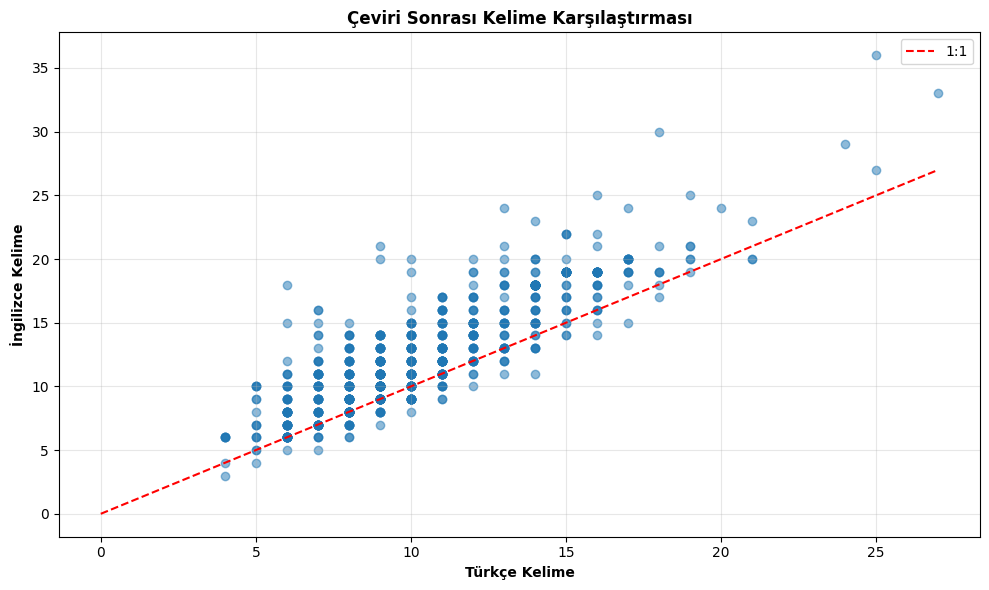

In [11]:
# Çeviri analizi
import matplotlib.pyplot as plt

if 'df' in locals() and not df.empty and 'english_text' in df.columns:
    df['tr_words'] = df['Metin'].astype(str).apply(lambda x: len(x.split()))
    df['en_words'] = df['english_text'].astype(str).apply(lambda x: len(x.split()))

    print(f"\n📊 Ortalama kelime sayısı:")
    print(f"  Türkçe: {df['tr_words'].mean():.1f}")
    print(f"  İngilizce: {df['en_words'].mean():.1f}")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(df['tr_words'], df['en_words'], alpha=0.5)
    ax.plot([0, df['tr_words'].max()], [0, df['tr_words'].max()], 'r--', label='1:1')
    ax.set_xlabel('Türkçe Kelime', fontweight='bold')
    ax.set_ylabel('İngilizce Kelime', fontweight='bold')
    ax.set_title('Çeviri Sonrası Kelime Karşılaştırması', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [12]:
import nltk

# NLTK'nın ihtiyaç duyduğu tüm paketleri indiriyoruz.
# Hata mesajında belirtilen eksik 'punkt_tab' paketi eklendi.
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) # <-- EKLENDİ
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Gerekli NLTK paketleri indirildi.")

✅ Gerekli NLTK paketleri indirildi.


In [13]:
# İngilizce veriyi içeren CSV dosyasını yükle
start_date_str = '2018-01-01'
end_date_str = '2018-12-31'
ingilizce_csv_path = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}-ingilizce.csv'

try:
    df = pd.read_csv(ingilizce_csv_path)
    # Boş (NaN) satırları temizle
    df.dropna(subset=['english_text'], inplace=True)
    df = df.reset_index(drop=True)

    # Lemmatization için POS-Tag (Kelime Türü) belirleme fonksiyonu
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    # Lemmatization fonksiyonu
    lemmatizer = WordNetLemmatizer()
    def lemmatize_text(text):
        if not isinstance(text, str): return ""
        tokens = nltk.word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        lemmatized_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens if w.isalpha() and w not in stop_words]
        return ' '.join(lemmatized_tokens)

    # Stemming fonksiyonu
    stemmer = PorterStemmer()
    def stem_text(text):
        if not isinstance(text, str): return ""
        tokens = nltk.word_tokenize(text.lower())
        stop_words = set(stopwords.words('english'))
        stemmed_tokens = [stemmer.stem(w) for w in tokens if w.isalpha() and w not in stop_words]
        return ' '.join(stemmed_tokens)

    # Lemmatization ve Stemming işlemlerini uygula
    df['lemmatized_text'] = df['english_text'].apply(lemmatize_text)
    df['stemmed_text'] = df['english_text'].apply(stem_text)

    # Sonuçları yeni bir CSV dosyasına kaydet
    kok_bulunmus_csv_path = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}-ingilizce-KokleriBulunmus.csv'
    df.to_csv(kok_bulunmus_csv_path, index=False)

    print("Lemmatization ve Stemming işlemleri tamamlandı ve sonuçlar kaydedildi.")
    display(df[['english_text', 'lemmatized_text', 'stemmed_text']].head())

except FileNotFoundError:
    print(f"Hata: '{ingilizce_csv_path}' dosyası bulunamadı. Lütfen bir önceki hücreyi çalıştırdığınızdan emin olun.")

Lemmatization ve Stemming işlemleri tamamlandı ve sonuçlar kaydedildi.


,english_text,lemmatized_text,stemmed_text
0,Stock market rose after four weeks Anadolu Agency,stock market rise four week anadolu agency,stock market rose four week anadolu agenc
1,Stock market application and finance simulatio...,stock market application finance simulation la...,stock market applic financ simul laboratori op...
2,high frequency transactions from the eyes of s...,high frequency transaction eye stock exchange ...,high frequenc transact eye stock exchang istan...
3,Borsa Istanbul's new president has been announ...,borsa istanbul new president announce uzmanpara,borsa istanbul new presid announc uzmanpara
4,sakarya university sakarya university,sakarya university sakarya university,sakarya univers sakarya univers


In [14]:
# Ön işleme analizi
import matplotlib.pyplot as plt

if 'df_final' in locals() and not df_final.empty:
    df_final['eng_w'] = df_final['english_text'].astype(str).apply(lambda x: len(x.split()))
    df_final['lem_w'] = df_final['lemmatized_text'].astype(str).apply(lambda x: len(x.split()))
    df_final['stem_w'] = df_final['stemmed_text'].astype(str).apply(lambda x: len(x.split()))

    means = [df_final['eng_w'].mean(), df_final['lem_w'].mean(), df_final['stem_w'].mean()]

    print(f"\n📊 Ortalama kelime sayıları:")
    print(f"  English: {means[0]:.1f}")
    print(f"  Lemmatized: {means[1]:.1f}")
    print(f"  Stemmed: {means[2]:.1f}")

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(['English', 'Lemmatized', 'Stemmed'], means,
                   color=['steelblue', 'orange', 'green'], edgecolor='black')
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h, f'{h:.1f}',
               ha='center', va='bottom', fontweight='bold')
    ax.set_ylabel('Ortalama Kelime', fontweight='bold')
    ax.set_title('Ön İşleme Etkisi', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()


In [15]:
# Veri analizi grafikleri
import matplotlib.pyplot as plt
import pandas as pd

if 'df_final' in locals() and not df_final.empty:
    # Aylık dağılım
    if 'Tarih' in df_final.columns:
        df_final['Tarih'] = pd.to_datetime(df_final['Tarih'], errors='coerce')
        df_final['Ay'] = df_final['Tarih'].dt.to_period('M')
        monthly = df_final['Ay'].value_counts().sort_index()

        fig, ax = plt.subplots(figsize=(12, 5))
        monthly.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
        ax.set_title('Aylık Haber Dağılımı', fontweight='bold')
        ax.set_xlabel('Ay', fontweight='bold')
        ax.set_ylabel('Haber Sayısı', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(monthly):
            ax.text(i, v+2, str(v), ha='center', fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
